In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

from spike_statistics.core import permutation_resampling_test

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

In [8]:
#############################

perform_zscore = False

if not perform_zscore:
    zscore_str = "-no-zscore"
else:
    zscore_str = ""

#################################

In [9]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("stimulus-lfp-response-mec" + zscore_str)
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [10]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [11]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))

In [12]:
lfp_action = actions['stimulus-lfp-response' + zscore_str]
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [13]:
lfp_results = pd.merge(sessions, lfp_results, how='left')

In [14]:
lfp_results = lfp_results.query('stim_location!="ms"')

In [15]:
def action_group(row):
    a = int(row.channel_group in [0,1,2,3])
    return f'{row.action}-{a}'
lfp_results['action_side_a'] = lfp_results.apply(action_group, axis=1)

In [16]:
lfp_results['stim_strength'] = lfp_results['stim_p_max'] / lfp_results['theta_energy']

In [17]:
# lfp_results_hemisphere = lfp_results.sort_values(
#     by=['action_side_a', 'stim_strength', 'signal_to_noise'], ascending=[True, False, False]
lfp_results_hemisphere = lfp_results.sort_values(
    by=['action_side_a', 'channel_group'], ascending=[True, False]
).drop_duplicates(subset='action_side_a', keep='first')
lfp_results_hemisphere.loc[:,['action_side_a','channel_group', 'signal_to_noise', 'stim_strength']].head()

,action_side_a,channel_group,signal_to_noise,stim_strength
71,1833-010719-1-0,7,0.001902,NaN
67,1833-010719-1-1,3,0.003522,NaN
583,1833-020719-1-0,7,-0.002942,NaN
579,1833-020719-1-1,3,0.012323,NaN
375,1833-020719-3-0,7,-0.002042,NaN


In [18]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
# Hz11 means that the baseline session was indeed before an 11 Hz session
queries = ['baseline and i and Hz11', 'frequency==11', 'baseline and ii and Hz30', 'frequency==30']

In [19]:
# prepare pairwise comparison: same animal same side same date different sessions

In [20]:
def make_entity_date_side(row):
    s = row.action_side_a.split('-')
    del s[2]
    return '-'.join(s)

In [21]:
lfp_results_hemisphere['entity_date_side'] = lfp_results_hemisphere.apply(make_entity_date_side, axis=1)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


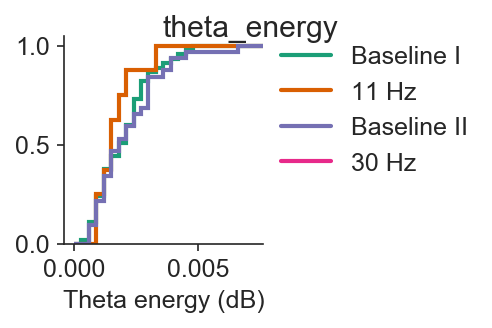

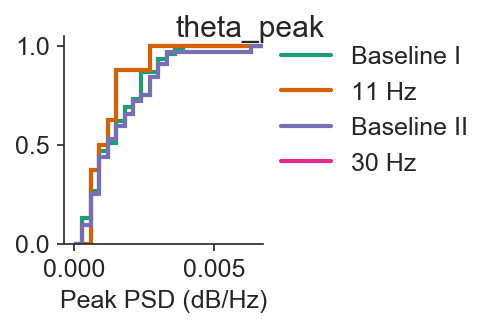

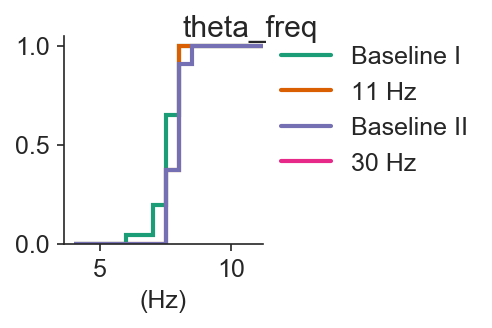

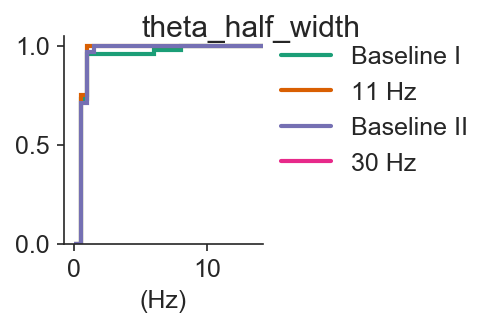

In [22]:

density = True
cumulative = True
histtype = 'step'
lw = 2
if perform_zscore:
    bins = {
        'theta_energy': np.arange(0, .7, .03),
        'theta_peak': np.arange(0, .7, .03),
        'theta_freq': np.arange(4, 10, .5),
        'theta_half_width': np.arange(0, 15, .5)
    }
else:
    bins = {
        'theta_energy': np.arange(0, .008, .0003),
        'theta_peak': np.arange(0, .007, .0003),
        'theta_freq': np.arange(4, 12, .5),
        'theta_half_width': np.arange(0, 15, .5)
    }
xlabel = {
    'theta_energy': 'Theta energy (dB)',
    'theta_peak': 'Peak PSD (dB/Hz)',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
}
# key = 'theta_energy'
# key = 'theta_peak'
results = {}
for key in bins:
    results[key] = list()
    fig = plt.figure(figsize=(3.5,2))
    plt.suptitle(key)
    legend_lines = []
    for color, query, label in zip(colors, queries, labels):
        values = lfp_results_hemisphere.query(query).loc[:,['entity_date_side', key]]
        results[key].append(values.rename({key: label}, axis=1))
        values[key].hist(
            bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
            histtype=histtype, color=color)
        legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        
    plt.legend(
        handles=legend_lines,
        bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.grid(False)
    plt.xlim(right=bins[key].max() - bins[key].max()*0.025)
    despine()
    plt.xlabel(xlabel[key])
    figname = f'lfp-psd-histogram-{key}'
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

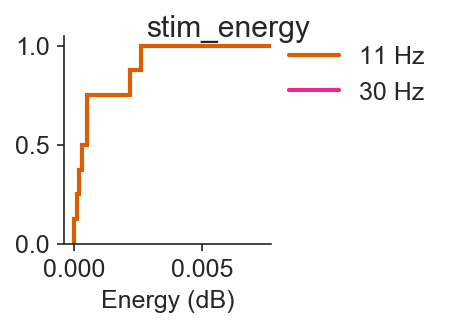

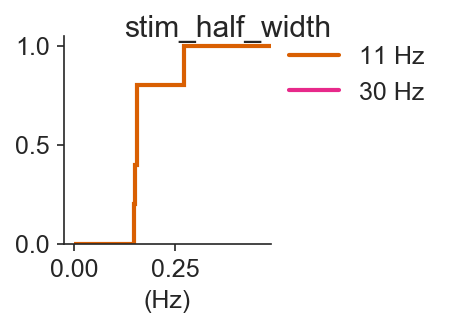

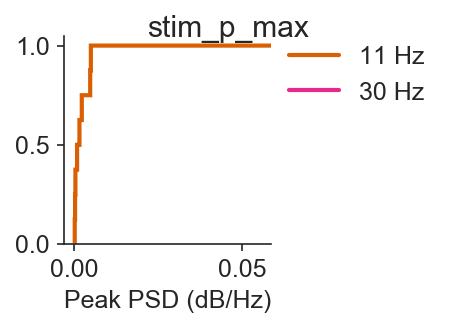

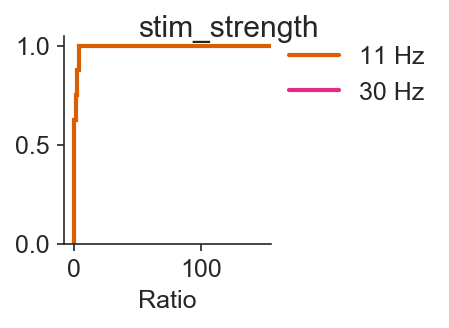

In [23]:

density = True
cumulative = True
histtype = 'step'
lw = 2
if perform_zscore:
    bins = {
        'stim_energy': np.arange(0, .7, .01),
        'stim_half_width': np.arange(0, 10, .5),
        'stim_p_max': np.arange(0, 4, .01),
        'stim_strength': np.arange(0, 160, 1)
    }
else:
    bins = {
        'stim_energy': np.arange(0, .008, .0001),
        'stim_half_width': np.arange(0, 0.5, .001),
        'stim_p_max': np.arange(0, .06, .0001),
        'stim_strength': np.arange(0, 160, 1)
    }
xlabel = {
    'stim_energy': 'Energy (dB)',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak PSD (dB/Hz)',
    'stim_strength': 'Ratio',
}
# key = 'theta_energy'
# key = 'theta_peak'
for key in bins:
    results[key] = list()
    fig = plt.figure(figsize=(3.2,2))
    plt.suptitle(key)
    legend_lines = []
    for color, query, label in zip(colors[1::2], queries[1::2], labels[1::2]):
        values = lfp_results_hemisphere.query(query).loc[:,['entity_date_side', key]]
        results[key].append(values.rename({key: label}, axis=1))
        values[key].hist(
            bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
            histtype=histtype, color=color)
        legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=lw, label=label))
        
    plt.legend(
        handles=legend_lines,
        bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
    plt.tight_layout()
    plt.grid(False)
    plt.xlim(right=bins[key].max() - bins[key].max()*0.025)
    despine()
    plt.xlabel(xlabel[key])
    figname = f'lfp-psd-histogram-{key}'
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

In [24]:
from functools import reduce

In [25]:
for key, val in results.items():
    df = reduce(lambda  left,right: pd.merge(left, right, on='entity_date_side', how='outer'), val)
    results[key] = df.drop('entity_date_side',axis=1)

In [26]:
def summarize(data):
    return "{:.1e} ± {:.1e} ({})".format(data.mean(), data.sem(), sum(~np.isnan(data)))


def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(),
        alternative='two-sided')

    return "{:.2f}, {:.3f}".format(Uvalue, pvalue)


def PRS(df, keys):
    '''
    Permutation ReSampling
    '''
    pvalue, observed_diff, diffs = permutation_resampling(
        df[keys[0]].dropna(), 
        df[keys[1]].dropna(), statistic=np.median)

    return "{:.2f}, {:.3f}".format(observed_diff, pvalue)


def wilcoxon(df, keys):
    dff = df.loc[:,keys].dropna()
    if len(dff[keys].dropna()) == 0:
        statistic, pvalue = np.nan, np.nan
    else:
        statistic, pvalue = scipy.stats.wilcoxon(
            dff[keys[0]], 
            dff[keys[1]],
            alternative='two-sided')

    return "{:.2f}, {:.3f}, ({})".format(statistic, pvalue, len(dff))


def paired_t(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.ttest_rel(
        dff[keys[0]], 
        dff[keys[1]])

    return "{:.2f}, {:.3f}".format(statistic, pvalue)

    
def normality(df, key):
    if len(df[key].dropna()) < 8:
        statistic, pvalue = np.nan, np.nan
    else:
        statistic, pvalue = scipy.stats.normaltest(
            df[key].dropna())

    return "{:.2f}, {:.3f}".format(statistic, pvalue)


def shapiro(df, key):
    if len(df[key].dropna()) < 8:
        statistic, pvalue = np.nan, np.nan
    else:
        statistic, pvalue = scipy.stats.shapiro(
            df[key].dropna())

    return "{:.2f}, {:.3f}".format(statistic, pvalue)

def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [27]:
results

{'theta_energy':     Baseline I     11 Hz  Baseline II  30 Hz
 0     0.003500       NaN          NaN    NaN
 1     0.001237       NaN          NaN    NaN
 2     0.003269       NaN     0.004628    NaN
 3     0.001465       NaN     0.002155    NaN
 4     0.002685       NaN          NaN    NaN
 5     0.000772       NaN          NaN    NaN
 6     0.002735       NaN     0.002988    NaN
 7     0.000872       NaN     0.001177    NaN
 8     0.004156       NaN     0.003132    NaN
 9     0.001317       NaN     0.001268    NaN
 10    0.000423       NaN     0.003200    NaN
 11    0.000957       NaN     0.001153    NaN
 12    0.002135       NaN     0.001651    NaN
 13    0.001649       NaN     0.000871    NaN
 14    0.009256       NaN     0.006838    NaN
 15    0.003803       NaN     0.003271    NaN
 16    0.004999       NaN     0.003724    NaN
 17    0.001193       NaN     0.002239    NaN
 18    0.004548  0.001780          NaN    NaN
 19    0.004548  0.001093          NaN    NaN
 20    0.002307  0

In [28]:


stat = pd.DataFrame()

for key, df in results.items():
    Key = rename(key)
    stat[Key] = df.agg(summarize)
    stat[Key] = df.agg(summarize)

    for i, c1 in enumerate(df.columns):
        stat.loc[f'Normality {c1}', Key] = normality(df, c1)
#         stat.loc[f'Shapiro {c1}', Key] = shapiro(df, c1)
        for c2 in df.columns[i+1:]:
#             stat.loc[f'MWU {c1} {c2}', Key] = MWU(df, [c1, c2])
#             stat.loc[f'PRS {c1} {c2}', Key] = PRS(df, [c1, c2])
            stat.loc[f'Wilcoxon {c1} {c2}', Key] = wilcoxon(df, [c1, c2])
#             stat.loc[f'Paired T {c1} {c2}', Key] = paired_t(df, [c1, c2])

stat.sort_index()

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


,Theta energy,Theta peak,Theta freq,Theta half width,Stim energy,Stim half width,Stim p max,Stim strength
11 Hz,1.8e-03 ± 2.8e-04 (8),1.4e-03 ± 2.6e-04 (8),8.1e+00 ± 5.3e-02 (8),8.9e-01 ± 7.4e-02 (8),8.4e-04 ± 3.6e-04 (8),2.2e+00 ± 1.4e+00 (8),1.9e-03 ± 7.0e-04 (8),1.2e+00 ± 5.6e-01 (8)
30 Hz,nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0),nan ± nan (0)
Baseline I,2.3e-03 ± 2.1e-04 (50),1.8e-03 ± 1.8e-04 (50),7.8e+00 ± 5.9e-02 (50),1.1e+00 ± 1.8e-01 (49),NaN,NaN,NaN,NaN
Baseline II,2.3e-03 ± 2.4e-04 (32),1.8e-03 ± 2.3e-04 (32),8.1e+00 ± 4.7e-02 (32),9.1e-01 ± 3.9e-02 (31),NaN,NaN,NaN,NaN
Normality 11 Hz,"8.13, 0.017","6.61, 0.037","6.30, 0.043","0.23, 0.890","3.45, 0.178","7.42, 0.024","1.81, 0.405","6.43, 0.040"
Normality 30 Hz,"nan, nan","nan, nan","nan, nan","nan, nan","nan, nan","nan, nan","nan, nan","nan, nan"
Normality Baseline I,"41.72, 0.000","31.09, 0.000","29.47, 0.000","81.74, 0.000",NaN,NaN,NaN,NaN
Normality Baseline II,"13.17, 0.001","20.78, 0.000","0.96, 0.618","13.33, 0.001",NaN,NaN,NaN,NaN
Wilcoxon 11 Hz 30 Hz,"nan, nan, (0)","nan, nan, (0)","nan, nan, (0)","nan, nan, (0)","nan, nan, (0)","nan, nan, (0)","nan, nan, (0)","nan, nan, (0)"
Wilcoxon 11 Hz Baseline II,"nan, nan, (0)","nan, nan, (0)","nan, nan, (0)","nan, nan, (0)",NaN,NaN,NaN,NaN


In [29]:
stat.to_latex(output_path / "statistics" / "statistics.tex")
stat.to_csv(output_path / "statistics" / "statistics.csv")

# Plot PSD

In [30]:
psd = pd.read_feather(pathlib.Path("output") / ("stimulus-lfp-response" + zscore_str) / 'data' / 'psd.feather')
freqs = pd.read_feather(pathlib.Path("output") / ("stimulus-lfp-response" + zscore_str) / 'data' / 'freqs.feather')

In [31]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [32]:
freq = freqs.T.iloc[0].values

mask = (freq < 49)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


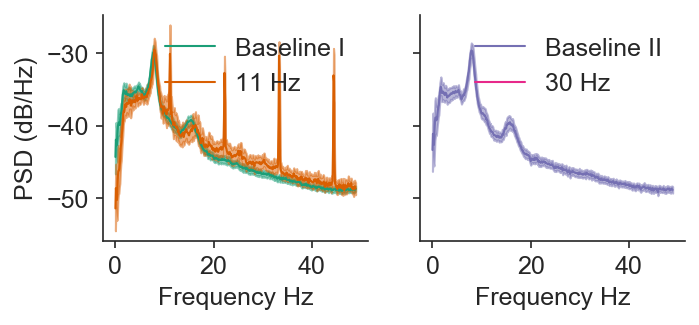

In [33]:

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
axs = axs.repeat(2)
for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
    selection = [
        f'{r.action}_{r.channel_group}' 
        for i, r in lfp_results_hemisphere.query(query).iterrows()]
    values = psd.loc[mask, selection].to_numpy()
    values = 10 * np.log10(values)
    plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
#     ax.set_title(titles[i])
    ax.set_xlabel('Frequency Hz')
    ax.legend(frameon=False)
axs[0].set_ylabel('PSD (dB/Hz)')
# axs[0].set_ylim(-31, 1)
despine()

figname = 'lfp-psd'
fig.savefig(
    output_path / 'figures' / f'{figname}.png', 
    bbox_inches='tight', transparent=True)
fig.savefig(
    output_path / 'figures' / f'{figname}.svg', 
    bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [34]:
action = project.require_action("stimulus-lfp-response-mec" + zscore_str)

In [35]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/statistics.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/statistics/statistics.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/figures/lfp-psd-histogram-stim_energy.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/figures/lfp-psd-histogram-stim_strength.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/figures/lfp-psd.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/figures/lfp-psd-histogram-theta_peak.svg',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/figures/lfp-psd-histogram-stim_p_max.png',
 '/media/storage/expipe/septum-mec/actions/stimulus-lfp-response-mec-no-zscore/data/figures/lfp-psd-histogram-theta_freq.png',
 '/media/storage/expipe/septum-

In [36]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-lfp-response-mec.ipynb")